In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
from sorted_crates import *
from top_crates import *
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

In [5]:
# Calls
all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [6]:
### Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls[
    const_calls.check_mode == "UnsafeBlockUserProvided"
]

slice_call = []
for x in user_written_unsafe_const_calls.def_path.unique():
    if x.endswith('slice::raw::from_raw_parts'):
        slice_call.append(x)
        break

parts = slice_call[0].split("[")
core_hash = parts[1].split("]")[0]
core_hash

'9834'

In [7]:
# Top X Crates
def norm(x):
    return x.lower().replace("-", "_")

top_250_compiling_crates = set(map(norm, sorted_crates[:250])) & set(map(norm, selected_builds.package.unique()))
top_250_crates_set = set(sorted_crates[:250])
top_250_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_250_crates_set)
top_250_builds = selected_builds[top_250_mask][
    ~selected_builds[top_250_mask]["package"].duplicated()
]
top_500_compiling_crates = set(map(norm, sorted_crates[:500])) & set(map(norm, selected_builds.package.unique()))
top_500_crates_set = set(sorted_crates[:500])
top_500_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_500_crates_set)
top_500_builds = selected_builds[top_500_mask][
    ~selected_builds[top_500_mask]["package"].duplicated()
]
top_1000_compiling_crates = set(map(norm, sorted_crates[:1000])) & set(map(norm, selected_builds.package.unique()))
top_1000_crates_set = set(sorted_crates[:1000])
top_1000_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_1000_crates_set)
top_1000_builds = selected_builds[top_1000_mask][
    ~selected_builds[top_1000_mask]["package"].duplicated()
]

In [8]:
print("Number of compiling crates in top 250:\t", len(top_250_compiling_crates))
print("Number of builds in top 250:\t\t", len(top_250_builds))
print("Number of expected crates in top 250:\t", len(sorted_crates[:250]))

Number of compiling crates in top 250:	 250
Number of builds in top 250:		 250
Number of expected crates in top 250:	 250


In [9]:
print("Number of compiling crates in top 500:\t", len(top_500_compiling_crates))
print("Number of builds in top 500:\t\t", len(top_500_builds))
print("Number of expected crates in top 500:\t", len(sorted_crates[:500]))

Number of compiling crates in top 500:	 497
Number of builds in top 500:		 497
Number of expected crates in top 500:	 500


In [10]:
print("Number of compiling crates in top 1000:\t", len(top_1000_compiling_crates))
print("Number of builds in top 1000:\t\t", len(top_1000_builds))
print("Number of expected crates in top 1000:\t", len(sorted_crates[:1000]))

Number of compiling crates in top 1000:	 973
Number of builds in top 1000:		 973
Number of expected crates in top 1000:	 1000


In [11]:
print("Number of selected builds:\t", len(selected_builds))
print("Number of crates total:\t\t", len(crates))

Number of selected builds:	 4889
Number of crates total:		 4889


------total------
ForeignItem    52440
Rust           42520
C               3110
system             2
sysv64             2
efiapi             1
Name: abi, dtype: int64

Percents:
ForeignItem    53.469284
Rust           43.354576
C               3.171043
system          0.002039
sysv64          0.002039
efiapi          0.001020
Name: abi, dtype: float64

Unsafe function definitions: 98075


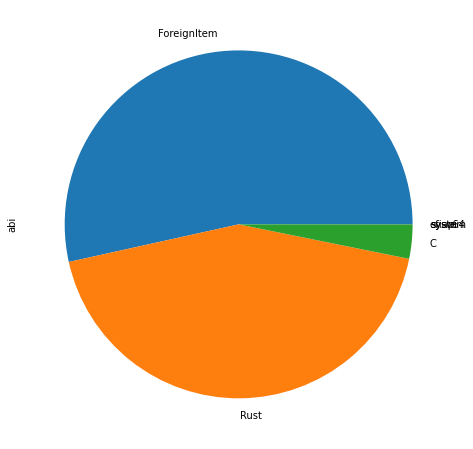

In [12]:
# Frequency of abi DEFINITIONS

values = unsafe_function_definitions.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents:")
print(values / len(unsafe_function_definitions) * 100)
print()
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()

del values

In [13]:
# Which crates define unsafe Rust functions?
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

print("------top 250------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_250_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 500------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_500_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 1000------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(top_1000_builds.crate)
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------total------")
values = def_unsafe_rust_funcs.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Top 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define unsafe Rust functions:	 93
Top 20 crates with most defined unsafe Rust functions:

futures_util        135
openssl              80
cloudabi             66
core_foundation      58
tokio                54
wasi                 45
aho_corasick         41
nix                  37
syscall              35
bytes                34
hashbrown            34
rayon_core           33
crossbeam_epoch      28
parking_lot          27
memchr               26
hyper                25
ppv_lite86           25
lock_api             23
parking_lot_core     21
futures_task         20
Name: crate, dtype: int64
------top 500------
Number of crates that define unsafe Rust functions:	 155
Top 20 crates with most defined unsafe Rust functions:

js_sys             803
clang_sys          349
web_sys            158
futures_util       135
git2               108
openssl             80
blake2b_simd        77
wasm_bindgen        74
cloudabi            66
core_foundation     58

In [14]:
# Which crates define C functions?
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]
values = def_c_funcs.crate.value_counts()

print("------top 250------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_250_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_250_builds)*100)
print(vals[:20])
print()
del vals, def_c

print("------top 500------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_500_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_500_builds)*100)
print(vals[:20])
print()
del vals, def_c

print("------top 1000------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(top_1000_builds.crate)
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_1000_builds)*100)
print(vals[:20])
print()
del vals, def_c

print("------total------")
print("Number of crates that define C functions:\t", len(values))
print("Percentage:\t\t\t\t\t", len(values)/len(selected_builds)*100)
print(values[:20])
del values

------top 250------
Number of crates that define C functions:	 4
Percentage:					 1.6
libc         27
openssl      18
backtrace     1
ring          1
Name: crate, dtype: int64

------top 500------
Number of crates that define C functions:	 7
Percentage:					 1.4084507042253522
wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
backtrace              1
ring                   1
Name: crate, dtype: int64

------top 1000------
Number of crates that define C functions:	 16
Percentage:					 1.644398766700925
wasm_bindgen           96
glib                   39
miniz_oxide_c_api      31
libc                   27
brotli_decompressor    18
openssl                18
block                  15
compiler_builtins       5
winit                   4
onig                    2
security_framework      2
zmq                     1
secp256k1               1
backtrace               1
ring                    1
rusqlite                1
Na

In [15]:
# Which crates define Foreign Items?
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]
values = def_fi_funcs.crate.value_counts()

print("------top 250------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_250_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_250_builds)*100)
print(vals[:20])
print()
del vals, def_fi

print("------top 500------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_500_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_500_builds)*100)
print(vals[:20])
print()
del vals, def_fi

print("------top 1000------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(top_1000_builds.crate)
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_1000_builds)*100)
print(vals[:20])
print()
del vals, def_fi

print("------total------")
print("Number of crates that define Foreign Items:\t", len(values))
print("Percentage:\t\t\t\t\t", len(values)/len(selected_builds)*100)
print(values[:20])
# crypto sneaks in here again
del values

------top 250------
Number of crates that define Foreign Items:	 8
Percentage:					 3.2
libc                   704
core_foundation_sys    232
ring                    74
libz_sys                56
cloudabi                49
wasi                    45
backtrace                4
backtrace_sys            3
Name: crate, dtype: int64

------top 500------
Number of crates that define Foreign Items:	 28
Percentage:					 5.633802816901409
libc                      704
libgit2_sys               593
libsqlite3_sys            272
core_foundation_sys       232
fuchsia_zircon_sys        139
libssh2_sys                96
ring                       74
security_framework_sys     57
libz_sys                   56
hermit_abi                 55
lzma_sys                   52
cloudabi                   49
wasi                       45
curl_sys                   44
brotli_sys                 23
crypto                     18
termios                    13
xattr                       8
miniz_sys                 

In [16]:
# Which crates define Foreign Items OR C?
either = [def_fi_funcs, def_c_funcs]
cfi_concatted = pd.concat(either)
values = cfi_concatted.crate.value_counts()

print("------top 250------")
top_concat = cfi_concatted[
    cfi_concatted.crate.isin(top_250_builds.crate)
]
vals = top_concat.crate.value_counts()
print("Number of crates that define C/Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_250_builds)*100)
print(vals[:20])
print()
del vals, top_concat

print("------top 500------")
top_concat = cfi_concatted[
    cfi_concatted.crate.isin(top_500_builds.crate)
]
vals = top_concat.crate.value_counts()
print("Number of crates that define C/Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_500_builds)*100)
print(vals[:20])
print()
del vals, top_concat

print("------top 1000------")
top_concat = cfi_concatted[
    cfi_concatted.crate.isin(top_1000_builds.crate)
]
vals = top_concat.crate.value_counts()
print("Number of crates that define C/Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t", len(vals)/len(top_1000_builds)*100)
print(vals[:20])
print()
del vals, top_concat

print("------total------")
print("Number of crates that define C/Foreign Items:\t", len(values))
print("Percentage:\t\t\t\t\t", len(values)/len(selected_builds)*100)
print(values[:20])

del values

------top 250------
Number of crates that define C/Foreign Items:	 9
Percentage:					 3.5999999999999996
libc                   731
core_foundation_sys    232
ring                    75
libz_sys                56
cloudabi                49
wasi                    45
openssl                 18
backtrace                5
backtrace_sys            3
Name: crate, dtype: int64

------top 500------
Number of crates that define C/Foreign Items:	 32
Percentage:					 6.438631790744467
libc                      731
libgit2_sys               593
libsqlite3_sys            272
core_foundation_sys       232
fuchsia_zircon_sys        139
wasm_bindgen               96
libssh2_sys                96
ring                       75
security_framework_sys     57
libz_sys                   56
hermit_abi                 55
lzma_sys                   52
cloudabi                   49
wasi                       45
curl_sys                   44
miniz_oxide_c_api          31
brotli_sys                 23
crypto    

------total------
Rust              85834
C                 29124
rust-intrinsic    17647
system              272
sysv64                2
Name: abi, dtype: int64

Percents: 
Rust              64.595610
C                 21.917685
rust-intrinsic    13.280503
system             0.204698
sysv64             0.001505
Name: abi, dtype: float64

Unsafe calls: 132879


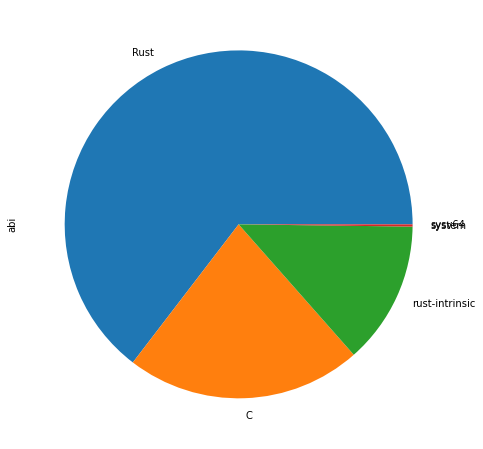

In [17]:
# Frequency of abi CALLS
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
values = unsafe_const_calls.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents: ")
print(values / len(unsafe_const_calls) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()

del values

In [18]:
# What are system and sysv64
calls_system = unsafe_const_calls[
    unsafe_const_calls.abi == "system"
]
calls_sysv64 = unsafe_const_calls[
    unsafe_const_calls.abi == "sysv64"
]

if len(calls_system) > 0:
    vals = calls_system[['crate_callsite', 'package_version']].apply(
        lambda row: (row['crate_callsite'], row['package_version']), axis=1
    ).squeeze().value_counts()
    
    print("Number of crates that call the system abi:\t", len(vals))
    print("Top 10 crates that call the system abi:")
    print(vals[:10])
    
if len(calls_sysv64) > 0:
    vals = calls_system[['crate_callsite', 'package_version']].apply(
        lambda row: (row['crate_callsite'], row['package_version']), axis=1
    ).squeeze().value_counts()
    
    print("Number of crates that call the sysv64 abi:\t", len(vals))
    print("Top 10 crates that call the sysv64 abi:")
    print(vals[:10])

Number of crates that call the system abi:	 9
Top 10 crates that call the system abi:
(ocl_core, 0.11.2)        70
(fil_ocl_core, 0.11.3)    70
(rusb, 0.6.5)             53
(odbc_safe, 0.5.0)        28
(winrt, 0.7.2)            19
(odbc, 0.17.0)            16
(skia, 0.30000023.1)      10
(whoami, 0.9.0)            5
(resolve, 0.2.0)           1
dtype: int64
Number of crates that call the sysv64 abi:	 9
Top 10 crates that call the sysv64 abi:
(ocl_core, 0.11.2)        70
(fil_ocl_core, 0.11.3)    70
(rusb, 0.6.5)             53
(odbc_safe, 0.5.0)        28
(winrt, 0.7.2)            19
(odbc, 0.17.0)            16
(skia, 0.30000023.1)      10
(whoami, 0.9.0)            5
(resolve, 0.2.0)           1
dtype: int64


In [19]:
# Which crates call unsafe Rust functions? - ALL
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]
#values = calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
#    lambda row: (row['crate_callsite'], row['package_version']), axis=1
#).squeeze().value_counts()

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]
values_uw = uw_calls_unsafe_rust_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

#print(len(values))
#print(len(values_uw))
#print()
#assert(len(values) == len(values_uw))
#del values

print("------top 250------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_250_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 500------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_500_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 1000------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(top_1000_builds.crate)
]
values = uw_urust[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------total------")
print("Number of crates that call unsafe Rust:\t", len(values_uw))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values_uw[:20])
del values_uw

------top 250------
Number of crates that call unsafe Rust:	 120
Top 20 crates with most unsafe Rust calls:	

(futures_util, 0.3.8)             478
(tokio, 0.3.4)                    415
(ppv_lite86, 0.2.10)              365
(openssl, 0.10.30)                342
(futures_util, 0.3.0-alpha.19)    235
(encoding_rs, 0.8.26)             233
(generic_array, 0.14.4)           188
(nix, 0.19.0)                     181
(itoa, 0.4.6)                     171
(hashbrown, 0.9.1)                159
(syscall, 0.2.1)                  127
(rayon, 1.5.0)                    119
(core_foundation, 0.9.1)          112
(smallvec, 1.5.0)                  91
(bstr, 0.2.14)                     83
(crossbeam_deque, 0.8.0)           79
(socket2, 0.3.17)                  75
(byteorder, 1.3.4)                 72
(hyper, 0.13.9)                    68
(lock_api, 0.4.2)                  66
dtype: int64

------top 500------
Number of crates that call unsafe Rust:	 206
Top 20 crates with most unsafe Rust calls:	

(js_sy

In [20]:
# Which crates call C functions?
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

print("------top 250------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_250_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Percentage:\t\t\t\t", len(values)/len(top_250_builds)*100)
print(values[:20])
print()
del values

print("------top 500------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_500_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Percentage:\t\t\t\t", len(values)/len(top_500_builds)*100)
print(values[:20])
print()
del values

print("------top 1000------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(top_1000_builds.crate)
]
values = calls_c[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Percentage:\t\t\t\t", len(values)/len(top_1000_builds)*100)
print(values[:20])
print()
del values

print("------total------")
values = calls_c_funcs[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Percentage:\t\t\t\t", len(values)/len(selected_builds)*100)
print(values[:20])
del values

------top 250------
Number of crates that call C functions:	 20
Percentage:				 8.0
(openssl, 0.10.30)               747
(nix, 0.19.0)                    351
(core_foundation, 0.9.1)         161
(ring, 0.17.0-alpha.7)            57
(socket2, 0.3.17)                 24
(mio_uds, 0.6.8)                  17
(net2, 0.2.35)                    13
(signal_hook_registry, 1.2.2)      5
(filetime, 0.2.13)                 5
(getrandom, 0.2.0)                 5
(backtrace, 0.3.55)                5
(chrono, 0.4.19)                   3
(tempfile, 3.1.0)                  3
(num_cpus, 1.13.0)                 3
(parking_lot_core, 0.8.0)          2
(atty, 0.2.14)                     1
(which, 4.0.2)                     1
(rand, 0.7.3)                      1
(tokio, 0.3.4)                     1
(tokio_uds, 0.2.7)                 1
dtype: int64

------top 500------
Number of crates that call C functions:	 49
Percentage:				 9.859154929577464
(openssl, 0.10.30)             747
(git2, 0.13.12)              

In [21]:
# Which crates [call OR define] [Foreign Items OR C]?
non_rust_calls_defs_concatted = calls_c_funcs.crate_callsite.append(def_c_funcs.crate).append(def_fi_funcs.crate)
values = non_rust_calls_defs_concatted.value_counts()

print("------top 250 non-Rust PMU------")
top_concat = non_rust_calls_defs_concatted[
    non_rust_calls_defs_concatted.isin(top_250_builds.crate)
]
vals = top_concat.value_counts()
print()
print("Number of crates that call/define C/Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t\t", len(vals)/len(top_250_builds)*100)
print(vals[:20])
print()
del vals, top_concat

print("------top 500 non-Rust PMU------")
top_concat = non_rust_calls_defs_concatted[
    non_rust_calls_defs_concatted.isin(top_500_builds.crate)
]
vals = top_concat.value_counts()
print()
print("Number of crates that call/define C/Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t\t", len(vals)/len(top_500_builds)*100)
print(vals[:20])
print()
del vals, top_concat

print("------top 1000 non-Rust PMU------")
top_concat = non_rust_calls_defs_concatted[
    non_rust_calls_defs_concatted.isin(top_1000_builds.crate)
]
vals = top_concat.value_counts()
print()
print("Number of crates that call/define C/Foreign Items:\t", len(vals))
print("Percentage:\t\t\t\t\t\t", len(vals)/len(top_1000_builds)*100)
print(vals[:20])
print()
del vals, top_concat

print("------total non-Rust PMU------")
print()
print("Number of crates that call/define C/Foreign Items:\t", len(values))
print("Percentage:\t\t\t\t\t\t", len(values)/len(selected_builds)*100)
print(values[:20])

del values

------top 250 non-Rust PMU------

Number of crates that call/define C/Foreign Items:	 26
Percentage:						 10.4
openssl                 765
libc                    731
nix                     351
core_foundation_sys     232
core_foundation         161
ring                    132
libz_sys                 56
cloudabi                 49
wasi                     45
socket2                  24
mio_uds                  17
net2                     13
backtrace                10
getrandom                 5
filetime                  5
signal_hook_registry      5
tempfile                  3
num_cpus                  3
chrono                    3
backtrace_sys             3
dtype: int64

------top 500 non-Rust PMU------

Number of crates that call/define C/Foreign Items:	 65
Percentage:						 13.078470824949697
openssl                   765
libc                      731
libgit2_sys               595
git2                      542
nix                       351
libsqlite3_sys            272
core_fou

In [22]:
# SIMD const calls
simd_functions = set([
    x
    for x in const_calls.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch')
])
simd_calls = const_calls[
    const_calls.def_path.isin(simd_functions)
]

print("------top 250------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_250_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Percentage:\t\t\t\t", len(simd_crates)/len(top_250_builds)*100)
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 500------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_500_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Percentage:\t\t\t\t", len(simd_crates)/len(top_500_builds)*100)
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 1000------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(top_1000_builds.crate)
]
simd_crates = top_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Percentage:\t\t\t\t", len(simd_crates)/len(top_1000_builds)*100)
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------total------")
simd_crates = simd_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("Number of SIMD calls:\t\t\t", len(simd_calls))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Percentage:\t\t\t\t", len(simd_crates)/len(selected_builds)*100)
print("Crates that call SIMD functions:")
print(simd_crates)
del simd_crates

------top 250------
Number of crates that call SIMD:	 6
Percentage:				 2.4
Crates that call SIMD functions:
(ppv_lite86, 0.2.10)    360
(bstr, 0.2.14)           16
(hashbrown, 0.9.1)        8
(sha1, 0.9.2)             2
(num_bigint, 0.3.1)       2
(sha2, 0.9.2)             2
dtype: int64

------top 500------
Number of crates that call SIMD:	 8
Percentage:				 1.6096579476861168
Crates that call SIMD functions:
(ppv_lite86, 0.2.10)    360
(bstr, 0.2.14)           16
(hashbrown, 0.9.1)        8
(sha1, 0.9.2)             2
(num_bigint, 0.3.1)       2
(rdrand, 0.7.0)           2
(sha2, 0.9.2)             2
(ahash, 0.5.8)            1
dtype: int64

------top 1000------
Number of crates that call SIMD:	 9
Percentage:				 0.9249743062692704
Crates that call SIMD functions:
(ppv_lite86, 0.2.10)    360
(bstr, 0.2.14)           16
(hashbrown, 0.9.1)        8
(libm, 0.2.1)             6
(sha1, 0.9.2)             2
(num_bigint, 0.3.1)       2
(rdrand, 0.7.0)           2
(sha2, 0.9.2)             

In [23]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [24]:
# Unchecked functions
const_unchecked_calls = const_calls[
    const_calls.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))
del const_unchecked_calls

print("------top 250------")
def filter_func(x):
    if x.split("[")[0] in top_250_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_250_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("unchecked_function_names:\t", count)
#print("Calls to unchecked functions:\t", len(top_unchecked))
#print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
#print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_250_builds)*100)
#print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------top 500------")
def filter_func(x):
    if x.split("[")[0] in top_500_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_500_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("unchecked_function_names:\t", count)
#print("Calls to unchecked functions:\t", len(top_unchecked))
#print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
#print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_500_builds)*100)
#print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------top 1000------")
def filter_func(x):
    if x.split("[")[0] in top_1000_builds.crate:
        return True
    else:
        return False

names = filter(filter_func, unchecked_function_names)
count = 0
for n in names:
    count+=1

top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(top_1000_builds.crate)
]
values = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("unchecked_function_names:\t", count)
#print("Calls to unchecked functions:\t", len(top_unchecked))
#print("Percentage:\t\t\t", len(top_unchecked)/len(unsafe_calls)*100)
#print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(top_1000_builds)*100)
#print(values)
print()
del values, names, count, top_unchecked, filter_func

print("------total------")
values = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
#print("unchecked_function_names:\t", len(unchecked_function_names))
#print("Calls to unchecked functions:\t", len(unchecked_calls))
#print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)
#print()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
#print(values)
del values

------top 250------
Number of crates:		 12
Percentage:			 4.8

------top 500------
Number of crates:		 25
Percentage:			 5.030181086519115

------top 1000------
Number of crates:		 37
Percentage:			 3.802672147995889

------total------
Number of crates:		 105
Percentage:			 2.1476784618531397


In [25]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))
print(unguarded_function_names)

const_unguarded_calls = const_calls[
    const_calls.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

if len(unguarded_calls) > 0:
    print(unguarded_calls)
    print("Calls to unguarded functions:\t", len(unguarded_calls))
    print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

#values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
#    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
#).squeeze().value_counts()
#print("Number of crates:\t\t", len(values))
#print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
#print(values[:5])

#print("Percentage of unsafe blocks with an unguarded function call:\t",
#     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
#)
#del values

unguarded_function_names:	 2
{'accountable_refcell[e43a]::{impl#10}::try_borrow_unguarded', 'pyo3[f821]::pycell::{impl#10}::try_borrow_unguarded'}
       build package_name package_version crate_callsite  build_crate_hash  \
88433   2266         pyo3          0.12.3           pyo3  dcb6ad2bf9f6637f   

       edition    block  unsafe_scope               check_mode     call  \
88433     2018  9125581       3812990  UnsafeBlockUserProvided  3437281   

      unsafety   abi  build_defsite package_name_defsite  \
88433   Unsafe  Rust           2266                 pyo3   

      package_version_defsite crate_name_defsite build_crate_hash_defsite  \
88433                  0.12.3               pyo3         dcb6ad2bf9f6637f   

       edition_defsite crate_defsite        crate_hash  \
88433             2018          pyo3  dcb6ad2bf9f6637f   

                                                def_path  \
88433  pyo3[f821]::pycell::{impl#10}::try_borrow_ungu...   

                          def_p

In [26]:
# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_intrinsic = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "rust-intrinsic"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

In [27]:
# OLD
unchecked_calls_old = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
top_unchecked_old = unchecked_calls_old[
    unchecked_calls_old.crate_callsite.isin(top_250_builds.crate)
]

# NEW
unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked_mut'))
])

unchecked_calls_new = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(unchecked)
]
top_unchecked_new = unchecked_calls_new[
    unchecked_calls_new.crate_callsite.isin(top_250_builds.crate)
]

In [28]:
unchecked_calls_old[
    unchecked_calls_old.crate_callsite == "bstr"
]

,build,package_name,package_version,crate_callsite,build_crate_hash,edition,block,unsafe_scope,check_mode,call,unsafety,abi,build_defsite,package_name_defsite,package_version_defsite,crate_name_defsite,build_crate_hash_defsite,edition_defsite,crate_defsite,crate_hash,def_path,def_path_hash,summary_key,block_defsite,unsafe_scope_defsite,check_mode_defsite,unsafety_defsite,abi_defsite
63179,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,2203197,890416,UnsafeBlockUserProvided,804761,Unsafe,Rust,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,bstr,dcb20f359a88b1c4,bstr[403b]::ext_vec::ByteVec::into_string_unch...,1ab882888ead36ed13140bbd5edc5e8b,bstr.ext_vec.ByteVec.into_string_unchecked,2203197,890416,UnsafeBlockUserProvided,Unsafe,Rust
63180,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,2203212,890419,UnsafeBlockUserProvided,804766,Unsafe,Rust,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,bstr,dcb20f359a88b1c4,bstr[403b]::ext_vec::ByteVec::into_string_unch...,1ab882888ead36ed13140bbd5edc5e8b,bstr.ext_vec.ByteVec.into_string_unchecked,2203212,890419,UnsafeBlockUserProvided,Unsafe,Rust
63207,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,2205321,891456,UnsafeBlockUserProvided,805672,Unsafe,Rust,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,bstr,dcb20f359a88b1c4,bstr[403b]::ext_slice::ByteSlice::to_str_unche...,bc3250d3c2660ef0dd08bc1d6316d20a,bstr.ext_slice.ByteSlice.to_str_unchecked,2205321,891456,UnsafeBlockUserProvided,Unsafe,Rust
63209,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,2205337,891464,UnsafeBlockUserProvided,805680,Unsafe,Rust,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,bstr,dcb20f359a88b1c4,bstr[403b]::ext_slice::ByteSlice::to_str_unche...,bc3250d3c2660ef0dd08bc1d6316d20a,bstr.ext_slice.ByteSlice.to_str_unchecked,2205337,891464,UnsafeBlockUserProvided,Unsafe,Rust
63211,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,2205403,891508,UnsafeBlockUserProvided,805705,Unsafe,Rust,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,bstr,dcb20f359a88b1c4,bstr[403b]::ext_slice::ByteSlice::to_str_unche...,bc3250d3c2660ef0dd08bc1d6316d20a,bstr.ext_slice.ByteSlice.to_str_unchecked,2205403,891508,UnsafeBlockUserProvided,Unsafe,Rust
63213,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,2205501,891582,UnsafeBlockUserProvided,805753,Unsafe,Rust,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,bstr,dcb20f359a88b1c4,bstr[403b]::ext_slice::ByteSlice::to_str_unche...,bc3250d3c2660ef0dd08bc1d6316d20a,bstr.ext_slice.ByteSlice.to_str_unchecked,2205501,891582,UnsafeBlockUserProvided,Unsafe,Rust


In [29]:
unchecked_calls_new[
    unchecked_calls_new.crate_callsite == "bstr"
]

,build,package_name,package_version,crate_callsite,build_crate_hash,edition,crate_defsite,crate_hash,def_path,def_path_hash,summary_key,block,unsafe_scope,check_mode,call,unsafety,abi
63074,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,core,cc32ef8c4c9fca6f,core[9834]::slice::{impl#0}::get_unchecked,1d592bf4b498ee24b767f9e3030053fd,core.slice.implement.get_unchecked,2202788,890174,UnsafeBlockUserProvided,804584,Unsafe,Rust
63076,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,core,cc32ef8c4c9fca6f,core[9834]::slice::{impl#0}::get_unchecked_mut,a0eefadfcac15dffa012283d52738c10,core.slice.implement.get_unchecked_mut,2202790,890174,UnsafeBlockUserProvided,804586,Unsafe,Rust
63115,382,bstr,0.2.14,bstr,dcb20f359a88b1c4,2015,core,cc32ef8c4c9fca6f,core[9834]::slice::{impl#0}::get_unchecked,1d592bf4b498ee24b767f9e3030053fd,core.slice.implement.get_unchecked,2205706,891712,UnsafeBlockUserProvided,805828,Unsafe,Rust


In [30]:
# Filter for get_unchecked calls
get_unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked_mut'))
])

get_unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(get_unchecked)
]

print("------top 250------")
top_unchecked = get_unchecked_calls[
    get_unchecked_calls.crate_callsite.isin(top_250_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_unchecked_calls)/len(top_250_builds)*100)
print()
print(cleaned_unchecked_calls[:20])
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 500------")
top_unchecked = get_unchecked_calls[
    get_unchecked_calls.crate_callsite.isin(top_500_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_unchecked_calls)/len(top_500_builds)*100)
print()
print(cleaned_unchecked_calls[:20])
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 1000------")
top_unchecked = get_unchecked_calls[
    get_unchecked_calls.crate_callsite.isin(top_1000_builds.crate)
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_unchecked_calls)/len(top_1000_builds)*100)
print()
print(cleaned_unchecked_calls[:20])
print()
del cleaned_unchecked_calls, top_unchecked

print("------total------")
cleaned_unchecked_calls = get_unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_unchecked_calls)/len(selected_builds)*100)
print()
print(cleaned_unchecked_calls[:20])
del cleaned_unchecked_calls

------top 250------
Number of crates that use get_unchecked[_mut]:	 14
Percentage:					 5.6000000000000005

(encoding_rs, 0.8.26)         113
(rayon, 1.5.0)                 30
(rand_hc, 0.2.0)               16
(fixedbitset, 0.3.1)           10
(crossbeam_deque, 0.8.0)       10
(httparse, 1.3.4)               9
(ryu, 1.0.5)                    4
(siphasher, 0.3.3)              4
(crossbeam_queue, 0.3.0)        3
(petgraph, 0.5.1)               3
(bstr, 0.2.14)                  3
(rand_core, 0.5.1)              2
(generic_array, 0.14.4)         2
(crossbeam_channel, 0.5.0)      1
dtype: int64

------top 500------
Number of crates that use get_unchecked[_mut]:	 27
Percentage:					 5.432595573440644

(lexical_core, 0.7.4)       245
(encoding_rs, 0.8.26)       113
(priority_queue, 1.0.3)      54
(rayon, 1.5.0)               30
(crypto, 0.2.36)             24
(crypto, 0.3.1)              24
(combine, 4.4.0)             16
(rand_hc, 0.2.0)             16
(json, 0.12.4)               12
(crossb

In [31]:
# Filter for any unchecked calls
any_unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if 'unchecked' in x
])

any_unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(any_unchecked)
]

print("------top 250------")
top_any_unchecked = any_unchecked_calls[
    any_unchecked_calls.crate_callsite.isin(top_250_builds.crate)
]
cleaned_any_unchecked_calls = top_any_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that contain unchecked:\t", len(cleaned_any_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_any_unchecked_calls)/len(top_250_builds)*100)
print()
print(cleaned_any_unchecked_calls[:20])
print()
del cleaned_any_unchecked_calls, top_any_unchecked

print("------top 500------")
top_any_unchecked = any_unchecked_calls[
    any_unchecked_calls.crate_callsite.isin(top_500_builds.crate)
]
cleaned_any_unchecked_calls = top_any_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that contain unchecked:\t", len(cleaned_any_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_any_unchecked_calls)/len(top_500_builds)*100)
print()
print(cleaned_any_unchecked_calls[:20])
print()
del cleaned_any_unchecked_calls, top_any_unchecked

print("------top 1000------")
top_any_unchecked = any_unchecked_calls[
    any_unchecked_calls.crate_callsite.isin(top_1000_builds.crate)
]
cleaned_any_unchecked_calls = top_any_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that contain unchecked:\t", len(cleaned_any_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_any_unchecked_calls)/len(top_1000_builds)*100)
print()
print(cleaned_any_unchecked_calls[:20])
print()
del cleaned_any_unchecked_calls, top_any_unchecked

print("------total------")
cleaned_any_unchecked_calls = any_unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that contain unchecked:\t", len(cleaned_any_unchecked_calls))
print("Percentage:\t\t\t\t\t", len(cleaned_any_unchecked_calls)/len(selected_builds)*100)
print()
print(cleaned_any_unchecked_calls[:20])
print()
del cleaned_any_unchecked_calls

------top 250------
Number of crates that contain unchecked:	 62
Percentage:					 24.8

(futures_util, 0.3.8)             450
(tokio, 0.3.4)                    333
(futures_util, 0.3.0-alpha.19)    221
(encoding_rs, 0.8.26)             131
(hyper, 0.13.9)                    60
(num_traits, 0.2.14)               48
(rayon, 1.5.0)                     42
(tokio_util, 0.5.0)                33
(http, 0.2.1)                      20
(reqwest, 0.10.9)                  18
(bstr, 0.2.14)                     17
(rand_hc, 0.2.0)                   16
(httparse, 1.3.4)                  14
(thread_local, 1.0.1)              12
(crossbeam_deque, 0.8.0)           10
(fixedbitset, 0.3.1)               10
(itoa, 0.4.6)                      10
(hashbrown, 0.9.1)                  9
(arrayvec, 0.5.2)                   8
(futures_core, 0.3.0-alpha.19)      8
dtype: int64

------top 500------
Number of crates that contain unchecked:	 96
Percentage:					 19.3158953722334

(futures_util, 0.3.8)             450


In [32]:
# Copies only
copies = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::intrinsics::copy')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy_nonoverlapping')
])

copy_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(copies)
]

# From Raw Parts
raw_parts = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts_mut')
])

raw_parts_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(raw_parts)
]

# As Ptr
as_ptr = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_ptr'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_mut_ptr'))
])

as_ptr_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(as_ptr)
]

# NO SIMD
no_simd = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::intrinsics::write_bytes')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy_nonoverlapping')
        or x.startswith('core[' + core_hash + ']::mem::transmute_copy')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts_mut')
        #or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_ptr'))
        #or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_mut_ptr'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked_mut'))
])

no_simd_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(no_simd)
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[' + core_hash + ']::core_arch')
        or x.startswith('core[' + core_hash + ']::intrinsics::write_bytes')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy')
        or x.startswith('core[' + core_hash + ']::intrinsics::copy_nonoverlapping')
        or x.startswith('core[' + core_hash + ']::mem::transmute_copy')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts')
        or x.startswith('core[' + core_hash + ']::slice::raw::from_raw_parts_mut')
        #or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_ptr'))
        #or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::as_mut_ptr'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked'))
        or (x.startswith('core[' + core_hash + ']::slice::{impl#') and x.endswith('}::get_unchecked_mut'))
])

perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]

# Rust INTRINSIC Calls
perf_mot_unsafe_intrinsics = set([
    x
    for x in user_written_unsafe_const_calls_intrinsic.def_path.unique()
    if (x.startswith('core[' + core_hash + ']::intrinsics::') and x.endswith('::transmute'))
])

# Performance-motivated Rust intrinsic calls
perf_mot_unsafe_intrinsic_calls = user_written_unsafe_const_calls_intrinsic[
    user_written_unsafe_const_calls_intrinsic.def_path.isin(perf_mot_unsafe_intrinsics)
]

non_simd_both = [no_simd_calls, perf_mot_unsafe_intrinsic_calls]
perf_mot_unsafe_allrust_calls_minus_simd = pd.concat(non_simd_both)
both = [perf_mot_unsafe_rust_calls, perf_mot_unsafe_intrinsic_calls]
perf_mot_unsafe_allrust_calls = pd.concat(both)

# ALL PMU (including non-Rust)
non_rust_calls_defs_concatted = calls_c_funcs.crate_callsite.append(def_c_funcs.crate).append(def_fi_funcs.crate)
all_pmu = perf_mot_unsafe_allrust_calls.crate_callsite.append(non_rust_calls_defs_concatted)

In [33]:
print("------top 250 intrinsics------")
print()

top_intr_calls = perf_mot_unsafe_intrinsic_calls[
    perf_mot_unsafe_intrinsic_calls.crate_callsite.isin(top_250_builds.crate)
]
intr_crates = top_intr_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w intrinsic calls:\t", len(intr_crates))
print("Percentage:\t\t\t\t", len(intr_crates)/len(top_250_builds)*100)
print(intr_crates[:20])
print()
del top_intr_calls, intr_crates

print("------top 500 intrinsics------")
print()

top_intr_calls = perf_mot_unsafe_intrinsic_calls[
    perf_mot_unsafe_intrinsic_calls.crate_callsite.isin(top_500_builds.crate)
]
intr_crates = top_intr_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w intrinsic calls:\t", len(intr_crates))
print("Percentage:\t\t\t\t", len(intr_crates)/len(top_500_builds)*100)
print(intr_crates[:20])
print()
del top_intr_calls, intr_crates

print("------top 1000 intrinsics------")
print()

top_intr_calls = perf_mot_unsafe_intrinsic_calls[
    perf_mot_unsafe_intrinsic_calls.crate_callsite.isin(top_1000_builds.crate)
]
intr_crates = top_intr_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w intrinsic calls:\t", len(intr_crates))
print("Percentage:\t\t\t\t", len(intr_crates)/len(top_1000_builds)*100)
print(intr_crates[:20])
print()
del top_intr_calls, intr_crates

print("------total intrinsics------")
print()

intr_crates = perf_mot_unsafe_intrinsic_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w intrinsic calls:\t", len(intr_crates))
print("Percentage:\t\t\t\t", len(intr_crates)/len(selected_builds)*100)
print(intr_crates[:20])
print()
del intr_crates

------top 250 intrinsics------

Number of crates w intrinsic calls:	 20
Percentage:				 8.0
(memchr, 2.3.4)                  12
(itoa, 0.4.6)                    10
(iovec, 0.1.4)                    6
(tokio, 0.3.4)                    6
(nix, 0.19.0)                     5
(aho_corasick, 0.7.15)            4
(ryu, 1.0.5)                      4
(num_traits, 0.2.14)              4
(tokio_threadpool, 0.1.18)        3
(crossbeam_utils, 0.8.0)          3
(syn, 1.0.48)                     3
(bstr, 0.2.14)                    2
(backtrace, 0.3.55)               2
(log, 0.4.11)                     1
(linked_hash_map, 0.5.3)          1
(tokio_reactor, 0.1.12)           1
(sha1, 0.6.0)                     1
(ring, 0.17.0-alpha.7)            1
(openssl, 0.10.30)                1
(tokio_current_thread, 0.1.7)     1
dtype: int64

------top 500 intrinsics------

Number of crates w intrinsic calls:	 43
Percentage:				 8.651911468812877
(cast, 0.2.3)               40
(wasm_bindgen, 0.2.68)      20
(proto

In [34]:
print("------top 250 Copy/Copy_Nonoverlapping------")
print()

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_250_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w copy calls:\t", len(crates_w_copy_calls))
print("Percentage:\t\t\t", len(crates_w_copy_calls)/len(top_250_builds)*100)
print(crates_w_copy_calls[:20])
print()
del top_copy_calls, crates_w_copy_calls

print("------top 500 Copy/Copy_Nonoverlapping------")
print()

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_500_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w copy calls:\t", len(crates_w_copy_calls))
print("Percentage:\t\t\t", len(crates_w_copy_calls)/len(top_500_builds)*100)
print(crates_w_copy_calls[:20])
print()
del top_copy_calls, crates_w_copy_calls

print("------top 1000 Copy/Copy_Nonoverlapping------")
print()

top_copy_calls = copy_calls[
    copy_calls.crate_callsite.isin(top_1000_builds.crate)
]
crates_w_copy_calls = top_copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w copy calls:\t", len(crates_w_copy_calls))
print("Percentage:\t\t\t", len(crates_w_copy_calls)/len(top_1000_builds)*100)
print(crates_w_copy_calls[:20])
print()
del top_copy_calls, crates_w_copy_calls

print("------total Copy/Copy_Nonoverlapping------")
print()

crates_w_copy_calls = copy_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w copy calls:\t", len(crates_w_copy_calls))
print("Percentage:\t\t\t", len(crates_w_copy_calls)/len(selected_builds)*100)
print(crates_w_copy_calls[:20])
print()
del crates_w_copy_calls

------top 250 Copy/Copy_Nonoverlapping------

Number of crates w copy calls:	 15
Percentage:			 6.0
(itoa, 0.4.6)             40
(byteorder, 1.3.4)        40
(rayon, 1.5.0)            17
(smallvec, 1.5.0)         13
(bytes, 0.6.0)             7
(nix, 0.19.0)              7
(rand_core, 0.5.1)         7
(arrayvec, 0.5.2)          5
(siphasher, 0.3.3)         4
(encoding_rs, 0.8.26)      4
(safemem, 0.3.3)           3
(bstr, 0.2.14)             3
(openssl, 0.10.30)         2
(byte_tools, 0.3.1)        1
(aho_corasick, 0.7.15)     1
dtype: int64

------top 500 Copy/Copy_Nonoverlapping------

Number of crates w copy calls:	 25
Percentage:			 5.030181086519115
(ahash, 0.5.8)           78
(byteorder, 1.3.4)       40
(itoa, 0.4.6)            40
(crypto, 0.3.1)          17
(crypto, 0.2.36)         17
(rayon, 1.5.0)           17
(smallvec, 1.5.0)        13
(rand_core, 0.5.1)        7
(bytes, 0.6.0)            7
(nix, 0.19.0)             7
(lexical_core, 0.7.4)     5
(arrayvec, 0.5.2)         5
(

In [35]:
print("------top 250 from_raw_parts------")
print()

top_raw_parts_calls = raw_parts_calls[
    raw_parts_calls.crate_callsite.isin(top_250_builds.crate)
]
crates_w_raw_parts_calls = top_raw_parts_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w from_raw_parts calls:\t", len(crates_w_raw_parts_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_raw_parts_calls)/len(top_250_builds)*100)
print(crates_w_raw_parts_calls[:20])
print()
del top_raw_parts_calls, crates_w_raw_parts_calls

print("------top 500 from_raw_parts------")
print()

top_raw_parts_calls = raw_parts_calls[
    raw_parts_calls.crate_callsite.isin(top_500_builds.crate)
]
crates_w_raw_parts_calls = top_raw_parts_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w from_raw_parts calls:\t", len(crates_w_raw_parts_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_raw_parts_calls)/len(top_500_builds)*100)
print(crates_w_raw_parts_calls[:20])
print()
del top_raw_parts_calls, crates_w_raw_parts_calls

print("------top 1000 from_raw_parts------")
print()

top_raw_parts_calls = raw_parts_calls[
    raw_parts_calls.crate_callsite.isin(top_1000_builds.crate)
]
crates_w_raw_parts_calls = top_raw_parts_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w from_raw_parts calls:\t", len(crates_w_raw_parts_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_raw_parts_calls)/len(top_1000_builds)*100)
print(crates_w_raw_parts_calls[:20])
print()
del top_raw_parts_calls, crates_w_raw_parts_calls

print("------total from_raw_parts------")
print()

crates_w_raw_parts_calls = raw_parts_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w from_raw_parts calls:\t", len(crates_w_raw_parts_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_raw_parts_calls)/len(selected_builds)*100)
print(crates_w_raw_parts_calls[:20])
print()
del crates_w_raw_parts_calls

------top 250 from_raw_parts------

Number of crates w from_raw_parts calls:	 25
Percentage:					 10.0
(syscall, 0.2.1)           64
(rand, 0.7.3)              44
(openssl, 0.10.30)         20
(byteorder, 1.3.4)         17
(itoa, 0.4.6)              10
(smallvec, 1.5.0)           5
(arrayvec, 0.5.2)           5
(ring, 0.17.0-alpha.7)      3
(bytes, 0.6.0)              3
(rand_isaac, 0.2.0)         2
(flate2, 1.0.19)            2
(generic_array, 0.14.4)     2
(rand_core, 0.5.1)          2
(rayon, 1.5.0)              2
(iovec, 0.1.4)              2
(nix, 0.19.0)               2
(utf8_ranges, 1.0.4)        1
(httparse, 1.3.4)           1
(ryu, 1.0.5)                1
(block_buffer, 0.9.0)       1
dtype: int64

------top 500 from_raw_parts------

Number of crates w from_raw_parts calls:	 44
Percentage:					 8.853118712273641
(syscall, 0.2.1)          64
(rand, 0.7.3)             44
(openssl, 0.10.30)        20
(byteorder, 1.3.4)        17
(git2, 0.13.12)           14
(itoa, 0.4.6)         

In [36]:
print("------top 250 as_ptr------")
print()

top_as_ptr_calls = as_ptr_calls[
    as_ptr_calls.crate_callsite.isin(top_250_builds.crate)
]
crates_w_as_ptr_calls = top_as_ptr_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w as_ptr calls:\t", len(crates_w_as_ptr_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_as_ptr_calls)/len(top_250_builds)*100)
print(crates_w_as_ptr_calls[:20])
print()
del top_as_ptr_calls, crates_w_as_ptr_calls

print("------top 500 as_ptr------")
print()

top_as_ptr_calls = as_ptr_calls[
    as_ptr_calls.crate_callsite.isin(top_500_builds.crate)
]
crates_w_as_ptr_calls = top_as_ptr_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w as_ptr calls:\t", len(crates_w_as_ptr_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_as_ptr_calls)/len(top_500_builds)*100)
print(crates_w_as_ptr_calls[:20])
print()
del top_as_ptr_calls, crates_w_as_ptr_calls

print("------top 1000 as_ptr------")
print()

top_as_ptr_calls = as_ptr_calls[
    as_ptr_calls.crate_callsite.isin(top_1000_builds.crate)
]
crates_w_as_ptr_calls = top_as_ptr_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w as_ptr calls:\t", len(crates_w_as_ptr_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_as_ptr_calls)/len(top_1000_builds)*100)
print(crates_w_as_ptr_calls[:20])
print()
del top_as_ptr_calls, crates_w_as_ptr_calls

print("------total as_ptr------")
print()

crates_w_as_ptr_calls = as_ptr_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates w as_ptr calls:\t", len(crates_w_as_ptr_calls))
print("Percentage:\t\t\t\t\t", len(crates_w_as_ptr_calls)/len(selected_builds)*100)
print(crates_w_as_ptr_calls[:20])
print()
del crates_w_as_ptr_calls

------top 250 as_ptr------

Number of crates w as_ptr calls:	 34
Percentage:					 13.600000000000001
(openssl, 0.10.30)          130
(ring, 0.17.0-alpha.7)      105
(byteorder, 1.3.4)           85
(generic_array, 0.14.4)      74
(encoding_rs, 0.8.26)        43
(nix, 0.19.0)                43
(rand, 0.7.3)                22
(syscall, 0.2.1)             17
(rand_core, 0.5.1)           11
(socket2, 0.3.17)             7
(bytes, 0.6.0)                6
(ppv_lite86, 0.2.10)          6
(core_foundation, 0.9.1)      5
(filetime, 0.2.13)            5
(mio_uds, 0.6.8)              4
(byte_tools, 0.3.1)           4
(bstr, 0.2.14)                3
(tokio, 0.3.4)                3
(net2, 0.2.35)                2
(ryu, 1.0.5)                  2
dtype: int64

------top 500 as_ptr------

Number of crates w as_ptr calls:	 57
Percentage:					 11.468812877263582
(openssl, 0.10.30)          130
(ring, 0.17.0-alpha.7)      105
(byteorder, 1.3.4)           85
(generic_array, 0.14.4)      74
(nix, 0.19.0)   

In [37]:
# PMU Rust CALLs
print("------top 250 Rust PMU------")
print()

top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_250_builds.crate)
]
pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(pmu_rust_calls))
print("Percentage:\t\t", len(pmu_rust_calls)/len(top_250_builds)*100)
print(pmu_rust_calls[:20])
print()

del top_pmu_rust_calls, pmu_rust_calls

print("------top 500 Rust PMU------")
print()

top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_500_builds.crate)
]
pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(pmu_rust_calls))
print("Percentage:\t\t", len(pmu_rust_calls)/len(top_500_builds)*100)
print(pmu_rust_calls[:20])
print()

del top_pmu_rust_calls, pmu_rust_calls

print("------top 1000 Rust PMU------")
print()

top_pmu_rust_calls = perf_mot_unsafe_allrust_calls[
    perf_mot_unsafe_allrust_calls.crate_callsite.isin(top_1000_builds.crate)
]
pmu_rust_calls = top_pmu_rust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(pmu_rust_calls))
print("Percentage:\t\t", len(pmu_rust_calls)/len(top_1000_builds)*100)
print(pmu_rust_calls[:20])
print()

del top_pmu_rust_calls, pmu_rust_calls

print("------total Rust PMU------")
print()

pmu_rust_calls = perf_mot_unsafe_allrust_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(pmu_rust_calls))
print("Percentage:\t\t", len(pmu_rust_calls)/len(selected_builds)*100)
print(pmu_rust_calls[:20])
print()

del pmu_rust_calls

------top 250 Rust PMU------

Number of crates:	 52
Percentage:		 20.8
(ppv_lite86, 0.2.10)        360
(encoding_rs, 0.8.26)       117
(syscall, 0.2.1)             66
(itoa, 0.4.6)                60
(byteorder, 1.3.4)           57
(rayon, 1.5.0)               49
(rand, 0.7.3)                44
(ring, 0.17.0-alpha.7)       25
(bstr, 0.2.14)               24
(openssl, 0.10.30)           23
(smallvec, 1.5.0)            18
(rand_hc, 0.2.0)             16
(nix, 0.19.0)                14
(memchr, 2.3.4)              12
(rand_core, 0.5.1)           11
(bytes, 0.6.0)               11
(crossbeam_deque, 0.8.0)     10
(arrayvec, 0.5.2)            10
(httparse, 1.3.4)            10
(fixedbitset, 0.3.1)         10
dtype: int64

------top 500 Rust PMU------

Number of crates:	 98
Percentage:		 19.718309859154928
(ppv_lite86, 0.2.10)       360
(lexical_core, 0.7.4)      252
(encoding_rs, 0.8.26)      117
(ahash, 0.5.8)              82
(syscall, 0.2.1)            66
(itoa, 0.4.6)               60
(byt

In [38]:
# No SIMD 
print("------top 250 Non-SIMD Rust PMU------")
print()

top_no_simd_calls = perf_mot_unsafe_allrust_calls_minus_simd[
    perf_mot_unsafe_allrust_calls_minus_simd.crate_callsite.isin(top_250_builds.crate)
]
no_simd_calls_vals = top_no_simd_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(no_simd_calls_vals))
print("Percentage:\t\t", len(no_simd_calls_vals)/len(top_250_builds)*100)
print(no_simd_calls_vals[:20])
print()

del top_no_simd_calls, no_simd_calls_vals

print("------top 500 Non-SIMD Rust PMU------")
print()

top_no_simd_calls = perf_mot_unsafe_allrust_calls_minus_simd[
    perf_mot_unsafe_allrust_calls_minus_simd.crate_callsite.isin(top_500_builds.crate)
]
no_simd_calls_vals = top_no_simd_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(no_simd_calls_vals))
print("Percentage:\t\t", len(no_simd_calls_vals)/len(top_500_builds)*100)
print(no_simd_calls_vals[:20])
print()

del top_no_simd_calls, no_simd_calls_vals

print("------top 1000 Non-SIMD Rust PMU------")
print()

top_no_simd_calls = perf_mot_unsafe_allrust_calls_minus_simd[
    perf_mot_unsafe_allrust_calls_minus_simd.crate_callsite.isin(top_1000_builds.crate)
]
no_simd_calls_vals = top_no_simd_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(no_simd_calls_vals))
print("Percentage:\t\t", len(no_simd_calls_vals)/len(top_1000_builds)*100)
print(no_simd_calls_vals[:20])
print()

del top_no_simd_calls, no_simd_calls_vals

print("------total Non-SIMD Rust PMU------")
print()

no_simd_calls_vals = perf_mot_unsafe_allrust_calls_minus_simd[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()

print("Number of crates:\t", len(no_simd_calls_vals))
print("Percentage:\t\t", len(no_simd_calls_vals)/len(selected_builds)*100)
print(no_simd_calls_vals[:20])
print()

del no_simd_calls_vals

------top 250 Non-SIMD Rust PMU------

Number of crates:	 47
Percentage:		 18.8
(encoding_rs, 0.8.26)       117
(syscall, 0.2.1)             66
(itoa, 0.4.6)                60
(byteorder, 1.3.4)           57
(rayon, 1.5.0)               49
(rand, 0.7.3)                44
(ring, 0.17.0-alpha.7)       25
(openssl, 0.10.30)           23
(smallvec, 1.5.0)            18
(rand_hc, 0.2.0)             16
(nix, 0.19.0)                14
(memchr, 2.3.4)              12
(rand_core, 0.5.1)           11
(bytes, 0.6.0)               11
(fixedbitset, 0.3.1)         10
(crossbeam_deque, 0.8.0)     10
(httparse, 1.3.4)            10
(arrayvec, 0.5.2)            10
(ryu, 1.0.5)                  9
(bstr, 0.2.14)                8
dtype: int64

------top 500 Non-SIMD Rust PMU------

Number of crates:	 92
Percentage:		 18.51106639839034
(lexical_core, 0.7.4)      252
(encoding_rs, 0.8.26)      117
(ahash, 0.5.8)              81
(syscall, 0.2.1)            66
(itoa, 0.4.6)               60
(byteorder, 1.3.4)

In [39]:
print("------top 250 of All PMU------")
print()

top_all_pmu = all_pmu[
    all_pmu.isin(top_250_builds.crate)
]
values = top_all_pmu.value_counts()

print("Number of crates:\t", len(values))
print("Percentage:\t\t", len(values)/len(top_250_builds)*100)
print(values[:20])

del top_all_pmu, values

print()
print("------top 500 of All PMU------")
print()

top_all_pmu = all_pmu[
    all_pmu.isin(top_500_builds.crate)
]
values = top_all_pmu.value_counts()

print("Number of crates:\t", len(values))
print("Percentage:\t\t", len(values)/len(top_500_builds)*100)
print(values[:20])

del top_all_pmu, values

print()
print("------top 1000 of All PMU------")
print()

top_all_pmu = all_pmu[
    all_pmu.isin(top_1000_builds.crate)
]
values = top_all_pmu.value_counts()

print("Number of crates:\t", len(values))
print("Percentage:\t\t", len(values)/len(top_1000_builds)*100)
print(values[:20])

del top_all_pmu, values

print()
print("------total of All PMU------")
print()

values = all_pmu.value_counts()

print("Number of crates:\t", len(values))
print("Percentage:\t\t", len(values)/len(selected_builds)*100)
print(values[:20])

del values

------top 250 of All PMU------

Number of crates:	 70
Percentage:		 28.000000000000004
openssl                788
libc                   731
nix                    365
ppv_lite86             360
core_foundation_sys    232
core_foundation        162
ring                   157
encoding_rs            117
syscall                 66
itoa                    60
byteorder               57
libz_sys                56
cloudabi                49
rayon                   49
wasi                    45
rand                    45
bstr                    24
socket2                 24
smallvec                18
mio_uds                 17
dtype: int64

------top 500 of All PMU------

Number of crates:	 144
Percentage:		 28.973843058350102
openssl                788
libc                   731
libgit2_sys            595
git2                   570
nix                    365
ppv_lite86             360
libsqlite3_sys         273
lexical_core           252
core_foundation_sys    232
core_foundation        162
r